Implementation of : http://cs229.stanford.edu/proj2012/ShenJiangZhang-StockMarketForecastingusingMachineLearningAlgorithms.pdf

In [516]:
import numpy as np
import pandas as pd
from datetime import datetime

from __future__ import print_function

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15,6)

# Data Preprocessing

In [517]:
input_data_path = 'Data/'

In [518]:
analysis_symbol = "IXIC"
available_col_list = ['NSEI', 'N225', 'HSI', 'GDAXI', 'AXJO', 'FTSE', 'EUR', 'AUD', 'JPY', 'HKD', 'GBP', 'GC',
                      'SI', 'PL', 'CB']
unavailable_col_list = ['IXIC', 'DJI', 'GSPC']

In [519]:
# Required as format of group is different from other group as obtained from several different sources.

nifty50_fnm = [('NSEI', '^NSEI.csv')]
indices_fnm1 = [('IXIC', '^IXIC.csv'), ('DJI', '^DJI.csv'), ('GSPC', '^GSPC.csv'),
               ('N225', '^N225.csv'), ('HSI', '^HSI.csv'), ('GDAXI', '^GDAXI.csv'),
               ('AXJO', '^AXJO.csv')]
indices_fnm2 = [('FTSE', '^FTSE.csv')]
currency_fnm = [('EUR', 'EUR_USD.csv'), ('AUD', 'AUD_USD.csv'), ('JPY', 'USD_JPY.csv'),
                ('HKD', 'USD_HKD.csv'), ('GBP', 'GBP_USD.csv')]
commodity_fnm = [('GC', 'gc.f.csv'), ('SI', 'si.f.csv'), ('PL', 'pl.f.csv'), ('CB', 'cb.f.csv')]

In [520]:
def load_data(nm, fnm, date_format, req_col_nm):
    df = pd.read_csv(input_data_path + fnm)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    df[nm] = pd.to_numeric(df[req_col_nm], errors='coerce')
    return(df[nm])

In [521]:
df_list = []
start_date = datetime(2001,1,3).date()
end_date = datetime(2012,10,25).date()
# end_date = datetime(2018,3,29).date()

for nm,fnm in nifty50_fnm:
    df = load_data(nm, fnm, '%d %b %Y', 'Close')
    df_list.append(df)
for nm,fnm in indices_fnm1:
    df = load_data(nm, fnm, '%Y-%m-%d', 'Adj Close')
    df_list.append(df)
for nm,fnm in indices_fnm2:
    df = load_data(nm, fnm, '%b %d %Y', 'Price')
    df_list.append(df)
for nm,fnm in currency_fnm:
    df = load_data(nm, fnm, '%b %d, %Y', 'Price')
    df_list.append(df)
for nm,fnm in commodity_fnm:
    df = load_data(nm, fnm, '%Y-%m-%d', 'Close')
    df_list.append(df)
    
df = pd.concat(df_list, axis=1)
df = df.reset_index()
df = df[(df['Date']>=start_date) & (df['Date']<=end_date)] # Selecting date range where all the variable are available
df.set_index('Date', inplace=True)
df.tail(50)

,NSEI,IXIC,DJI,GSPC,N225,HSI,GDAXI,AXJO,FTSE,EUR,AUD,JPY,HKD,GBP,GC,SI,PL,CB
Date,,,,,,,,,,,,,,,,,,
2012-08-20,NaN,3076.209961,13271.639648,1418.130005,9171.160156,20104.269531,7033.680176,4364.299805,5824.37,1.2344,1.0444,79.42,7.7572,1.5711,1620.85,2874.0,1493.20,113.61
2012-08-21,5421.00,3067.260010,13203.580078,1413.170044,9156.919922,20100.089844,7089.319824,4383.399902,5857.52,1.2472,1.0488,79.28,7.7568,1.5784,1638.45,2925.5,1510.55,114.86
2012-08-22,5412.85,3073.669922,13172.759766,1413.489990,9131.740234,19887.779297,7017.750000,4376.000000,5774.20,1.2528,1.0505,78.58,7.7563,1.5881,1654.15,2976.7,1537.70,115.03
2012-08-23,5415.35,3053.399902,13057.459961,1402.079956,9178.120117,20132.240234,6949.569824,4383.700195,5776.60,1.2564,1.0440,78.48,7.7564,1.5859,1671.05,3052.3,1546.30,114.44
2012-08-24,5386.70,3069.790039,13157.969727,1411.130005,9070.759766,19880.029297,6971.069824,4349.000000,5776.60,1.2513,1.0404,78.67,7.7569,1.5812,1670.75,3073.5,1550.45,113.47
2012-08-27,5350.25,3073.189941,13124.669922,1410.439941,9085.389648,19798.669922,7047.450195,4343.700195,NaN,1.2500,1.0371,78.75,7.7561,1.5794,1663.65,3075.2,1544.15,112.59
2012-08-28,5334.60,3077.139893,13102.990234,1409.300049,9033.290039,19811.800781,7002.680176,4359.399902,5775.71,1.2565,1.0376,78.51,7.7562,1.5818,1667.15,3092.8,1519.30,112.40
2012-08-29,5287.80,3081.189941,13107.480469,1410.489990,9069.809570,19788.509766,7010.569824,4356.399902,5743.53,1.2529,1.0352,78.70,7.7556,1.5833,1656.45,3076.7,1517.00,112.78
2012-08-30,5315.05,3048.709961,13000.709961,1399.479980,8983.780273,19552.910156,6895.490234,4315.700195,5719.45,1.2506,1.0290,78.62,7.7561,1.5786,1655.35,3048.7,1508.55,112.79


#### Analysing Null values and filling with previous value whenever possible

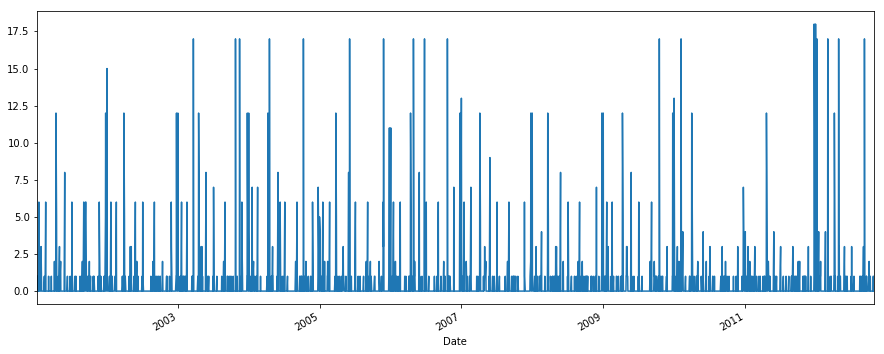

In [522]:
df.isnull().sum(axis=1).plot()

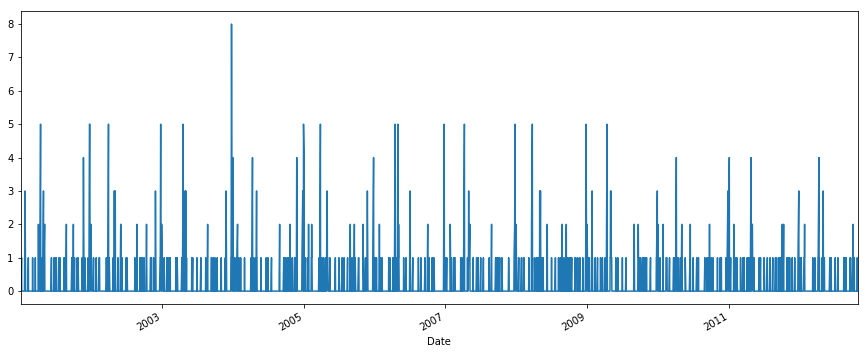

In [523]:
df1 = df.dropna(subset=[analysis_symbol])
df1.isnull().sum(axis=1).plot()

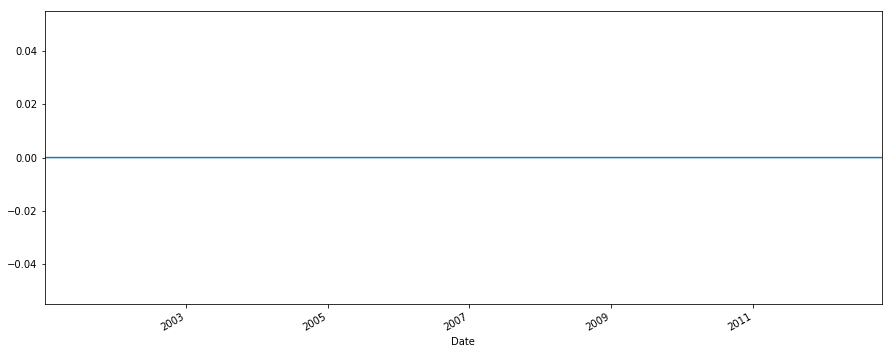

In [524]:
df2 = df1.fillna(method='ffill')
df2.dropna(inplace=True)
df2.isnull().sum(axis=1).plot()

# Temporal Correlation with Indices and Commodities

In [525]:
def delta_day_return(df, delta):
# Calculates moving returns over last delta days
    dfr = pd.DataFrame()
    for col in df.columns:
        dfr[col] = df[col].pct_change(periods=delta)
    return(dfr)

def cross_corr(x, df, start_lag, end_lag):
# Calculates cross correlation of x with all columns in df for all possible lags in between start_lag and end_lag
    corr_val = []
    for lag in range(start_lag, end_lag+1):
        corr_val_lag = []
        for col in df.columns:
            corr_val_lag.append(x.corr(df[col].shift(lag)))
        corr_val.append(corr_val_lag)
    return(pd.DataFrame(corr_val, index=range(start_lag, end_lag+1), columns=df.columns))

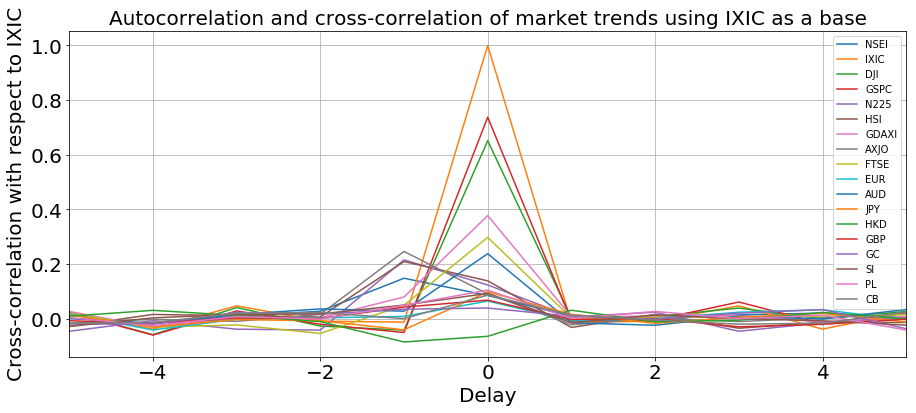

In [526]:
df3 = delta_day_return(df2,1)
df3 = df3.div(abs(df3))
df3.dropna(inplace=True)
corr_df = cross_corr(df3[analysis_symbol], df3, -5, 5)
corr_df.plot()
plt.grid()
plt.ylabel('Cross-correlation with respect to {}'.format(analysis_symbol), fontsize=20)
plt.xlabel('Delay', fontsize=20)
plt.title('Autocorrelation and cross-correlation of market trends using {} as a base'.format(analysis_symbol),
          fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

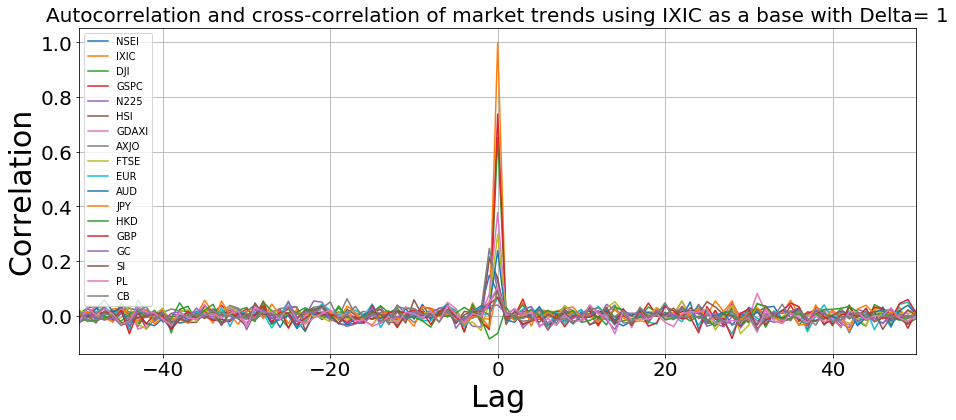

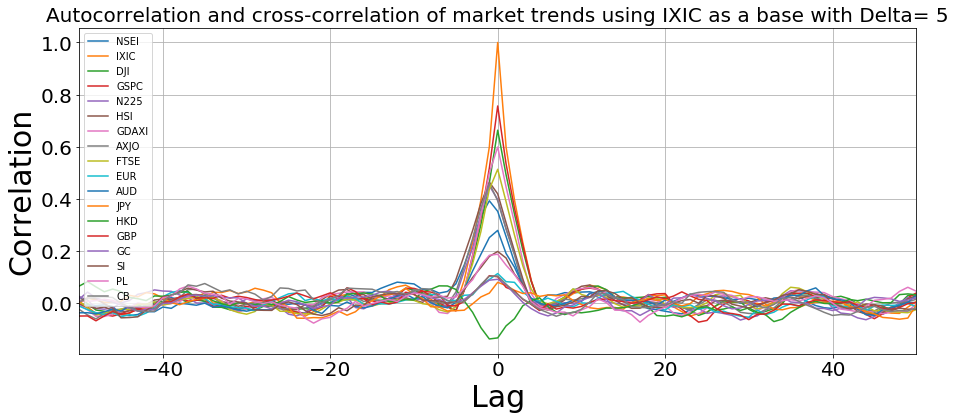

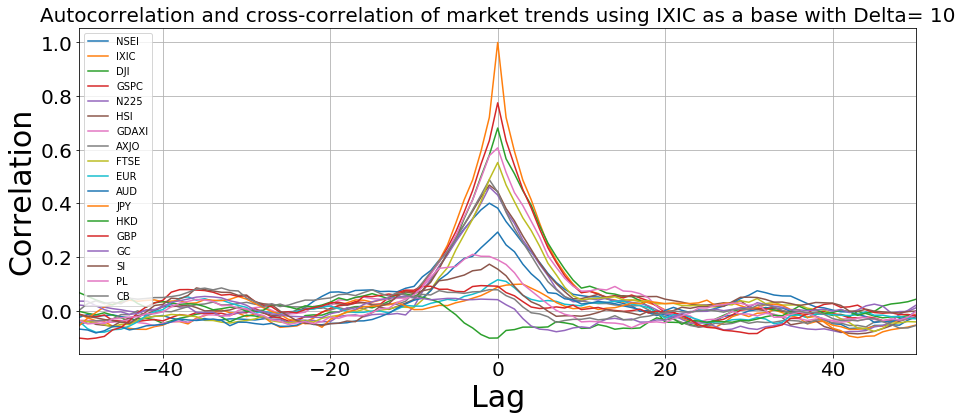

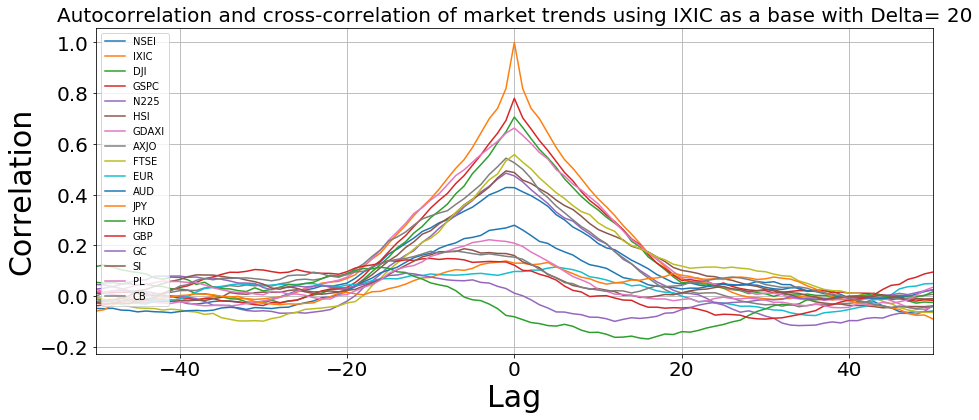

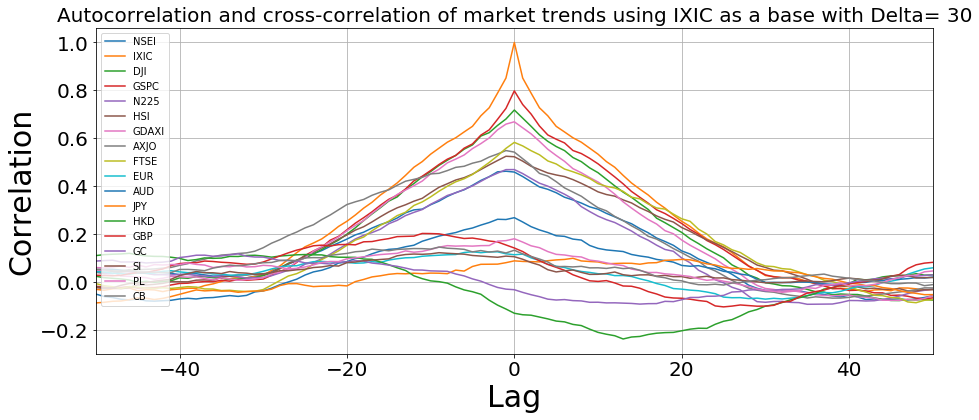

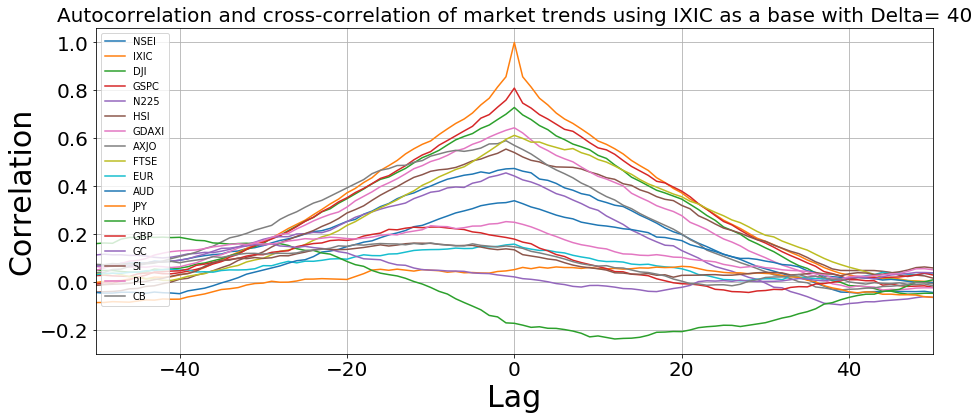

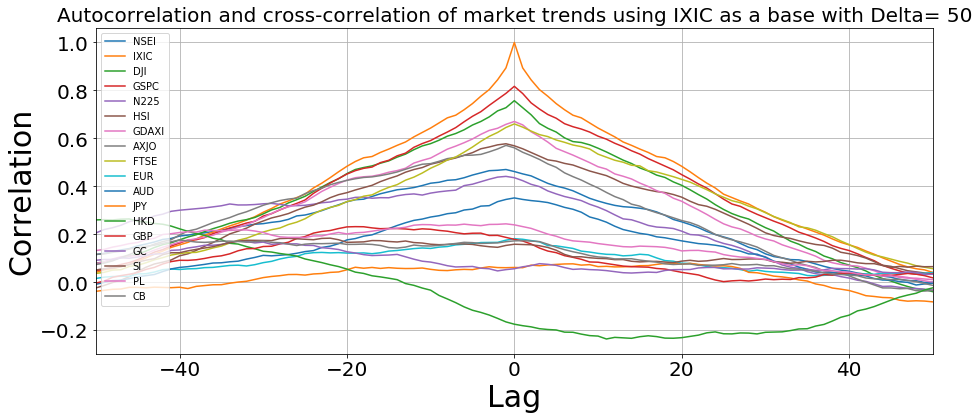

In [527]:
delta_list = [1,5,10,20,30,40,50]
for delta in delta_list:
    df6 = delta_day_return(df2,delta)
    df6 = df6.div(abs(df6))
    df6.dropna(inplace=True)
    corr_df = cross_corr(df6[analysis_symbol], df6, -50, 50)
    corr_df.plot()
    plt.grid()
    plt.ylabel('Correlation', fontsize=30)
    plt.xlabel('Lag', fontsize=30)
    plt.title('Autocorrelation and cross-correlation of market trends using {0} as a base with Delta= {1}'
              .format(analysis_symbol, str(delta)), fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(loc='upper left')

## Trend Prediction using Single Feature

In [528]:
print(__doc__)

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
# n_samples = all_features_df.shape[0]
X1 = df3[['GDAXI']]
y1 = df3[analysis_symbol]

# Split the dataset in two equal parts
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(solver='lbfgs'), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X1_train, y1_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y1_test, clf.predict(X1_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.001}

Grid scores on development set:

0.705 (+/-0.066) for {'C': 0.001}
0.705 (+/-0.066) for {'C': 0.01}
0.705 (+/-0.066) for {'C': 0.1}
0.705 (+/-0.066) for {'C': 1}
0.705 (+/-0.066) for {'C': 10}
0.705 (+/-0.066) for {'C': 100}
0.705 (+/-0.066) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

        -1.0       0.64      0.69      0.66       481
         1.0       0.71      0.66      0.69       562

    accuracy                           0.67      1043
   macro avg       0.68      0.68      0.67      1043
weighted avg       0.68      0.67      0.68      1043


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.001}

Grid scores

/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

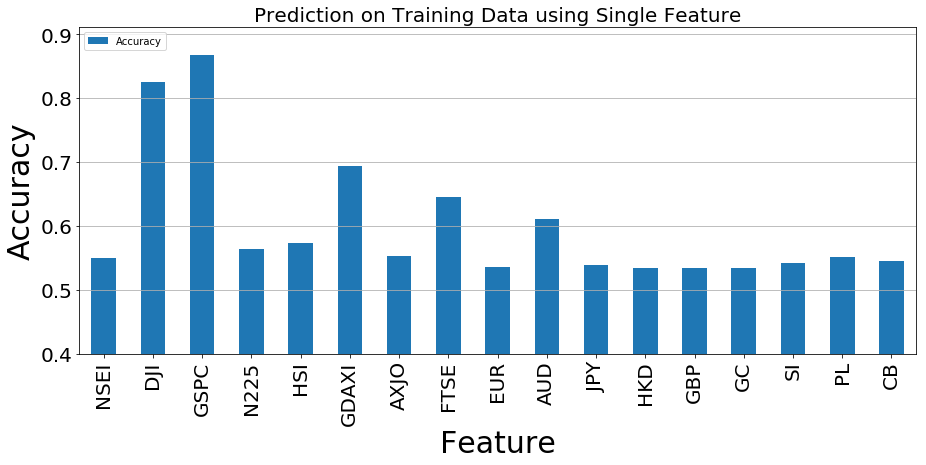

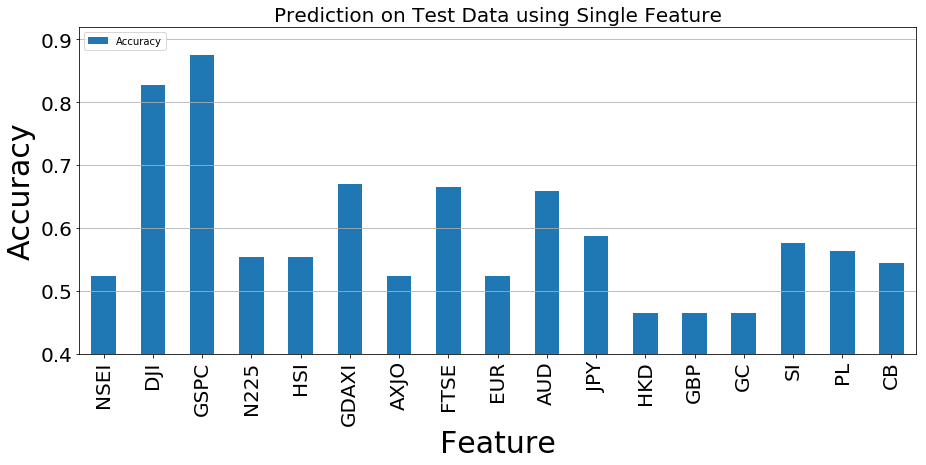

In [529]:
df7 = df2.copy()
df7.dropna(inplace=True)
df7 = delta_day_return(df7,1)
df7 = df7.div(abs(df7))
df7.dropna(inplace=True)
# df7['NSEI'] = df7['NSEI'].map(lambda x: 1 if(x>=0) else 0)
train_df, test_df = train_test_split(df7, test_size=0.2)
train_acc = []
test_acc = []
for col in train_df.columns:
    if(col != analysis_symbol):
        classifier = LogisticRegression(solver='warn', C=1, random_state=0)
        classifier.fit(train_df[[col]], train_df[analysis_symbol])
        train_acc.append((col, classifier.score(train_df[[col]], train_df[analysis_symbol])))
        test_acc.append((col, classifier.score(test_df[[col]], test_df[analysis_symbol])))
    
train_acc_df = pd.DataFrame(train_acc, columns=['Feature', 'Accuracy'])
train_acc_df.set_index('Feature', inplace=True)
ax = train_acc_df.plot.bar()
ax.yaxis.grid()
ax.set_ylim(bottom=0.4)
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Training Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

test_acc_df = pd.DataFrame(test_acc, columns=['Feature', 'Accuracy'])
test_acc_df.set_index('Feature', inplace=True)
ax = test_acc_df.plot.bar()
ax.yaxis.grid()
ax.set_ylim(bottom=0.4)
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Test Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

In [530]:
classifier

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [531]:
sum(train_df[analysis_symbol]==1)/len(train_df[analysis_symbol]) # Fraction of positive movements in training data (same as training acc)

0.5341726618705036

In [532]:
cm = metrics.confusion_matrix(test_df[analysis_symbol], classifier.predict(test_df[['GSPC']]))
print(cm)

[[192  31]
 [ 21 173]]


/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

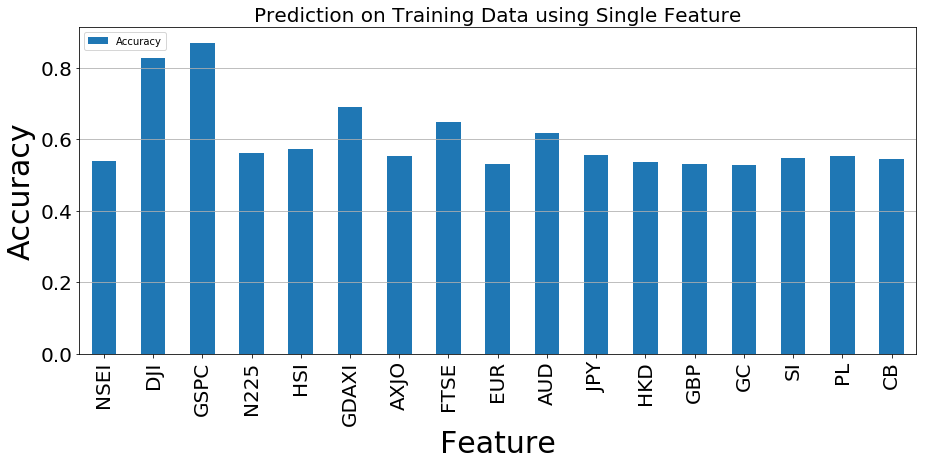

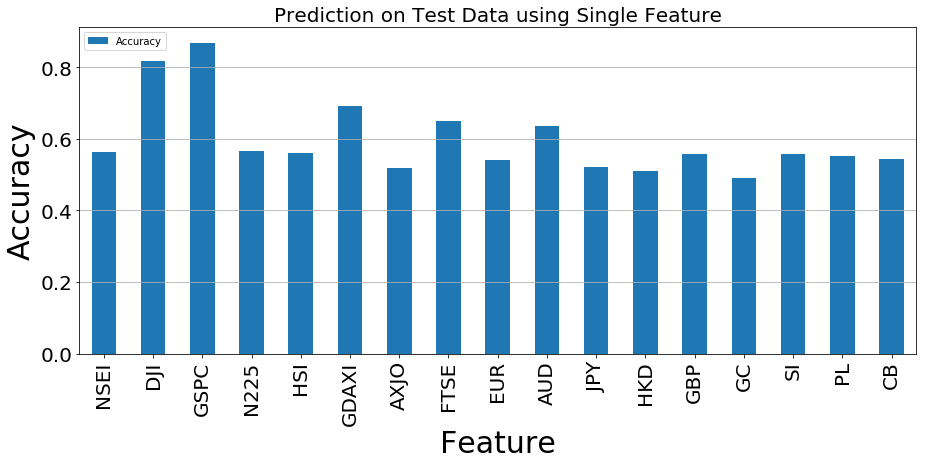

In [533]:
df7 = df2.copy()
df7.dropna(inplace=True)
df7 = delta_day_return(df7,1)
df7 = df7.div(abs(df7))
df7.dropna(inplace=True)
# df7['NSEI'] = df7['NSEI'].map(lambda x: 1 if(x>=0) else 0)
train_df, test_df = train_test_split(df7, test_size=0.2)
train_acc = []
test_acc = []
for col in train_df.columns:
    if(col != analysis_symbol):
        classifier = LogisticRegression(solver='warn', C=100, random_state=0)
        classifier.fit(train_df[[col]], train_df[analysis_symbol])
        train_acc.append((col, classifier.score(train_df[[col]], train_df[analysis_symbol])))
        test_acc.append((col, classifier.score(test_df[[col]], test_df[analysis_symbol])))
    
train_acc_df = pd.DataFrame(train_acc, columns=['Feature', 'Accuracy'])
train_acc_df.set_index('Feature', inplace=True)
ax = train_acc_df.plot.bar()
ax.yaxis.grid()
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Training Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

test_acc_df = pd.DataFrame(test_acc, columns=['Feature', 'Accuracy'])
test_acc_df.set_index('Feature', inplace=True)
ax = test_acc_df.plot.bar()
ax.yaxis.grid()
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Test Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

In [534]:
classifier

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Multi Feature Prediction

In [535]:
unavailable_lagged_df = df2[unavailable_col_list].shift(1)
unavailable_lagged_df.columns = [col + "_1" for col in unavailable_lagged_df]
all_df_list = [df2[available_col_list], unavailable_lagged_df]
df_t = pd.concat(all_df_list, axis=1)
df_t.dropna(inplace=True)

In [536]:
delta_list = [1,5,10,20,30,40,50]
target = delta_day_return(df2[[analysis_symbol]],1)
target = target.div(abs(target))

features_df_list = [target]
for delta in delta_list:
    df7 = delta_day_return(df_t,delta)
    df7 = df7.div(abs(df7))
    df7.columns = [x + '_d' + str(delta) for x in df7.columns]
    features_df_list.append(df7)
all_features_df = pd.concat(features_df_list, axis=1)
all_features_df.dropna(inplace=True)

In [537]:
train_df, test_df = train_test_split(all_features_df, test_size=0.2, random_state=0)

d1_col_list = [col for col in train_df.columns if(col[-3:]=="_d1")]
all_features_col_list = [col for col in train_df.columns if(col!=analysis_symbol)]
X_d1_train = train_df[d1_col_list]
X_train = train_df[all_features_col_list]
y_train = train_df[analysis_symbol]

X_d1_test = test_df[d1_col_list]
X_test = test_df[all_features_col_list]
y_test = test_df[analysis_symbol]

## Prediction using SVM
#### Using SVM on Features with lag=1

In [538]:
print(__doc__)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_d1_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_d1_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/li

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.677 (+/-0.041) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.258 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.679 (+/-0.040) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.677 (+/-0.038) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.679 (+/-0.040) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.679 (+/-0.040) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.679 (+/-0.031) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.679 (+/-0.040) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.679 (+/-0.040) for {'C': 1, 'kernel': 'linear'}
0.679 (+/-0.040) for {'C': 10, 'kernel': 'linear'}
0.679 (+/-0.040) for {'C': 100, 'kernel': 'linear'}
0.679 (+/-0.040) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             

In [539]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_d1_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_d1_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, clf.predict(X_d1_train)))))

cm_test = confusion_matrix(y_test, clf.predict(X_d1_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, clf.predict(X_d1_test)))))

Train Confusion Matrix:
[[428 216]
 [210 475]]
Train Accuracy: 0.6794582392776524

Test Confusion Matrix:
[[110  47]
 [ 54 122]]
Test Accuracy: 0.6966966966966966


In [540]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

#### Using SVM on Features with all lag values (1,5,10,20,30,40,50)

In [541]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, clf.predict(X_train)))))

cm_test = confusion_matrix(y_test, clf.predict(X_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, clf.predict(X_test)))))

Train Confusion Matrix:
[[463 181]
 [154 531]]
Train Accuracy: 0.7479307750188111

Test Confusion Matrix:
[[101  56]
 [ 49 127]]
Test Accuracy: 0.6846846846846847


In [542]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Prediction using LightGBM
#### Using LightGBM on Features with lag=1

In [543]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 10
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_d1_train, label=y_train), 1000)
d1_train_pred = np.where(clf.predict(X_d1_train)>=thres, 1, -1)
d1_test_pred = np.where(clf.predict(X_d1_test)>=thres, 1, -1)

cm_train = confusion_matrix(y_train, d1_train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, d1_train_pred))))

cm_test = confusion_matrix(y_test, d1_test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, d1_test_pred))))

Train Confusion Matrix:
[[429 215]
 [143 542]]
Train Accuracy: 0.7306245297215952

Test Confusion Matrix:
[[ 97  60]
 [ 44 132]]
Test Accuracy: 0.6876876876876877


#### Using LightGBM on features with all lags

In [544]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['lambda'] = 1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_train, label=y_train), 1000)
train_pred = np.where(clf.predict(X_train)>=thres, 1, -1)
test_pred = np.where(clf.predict(X_test)>=thres, 1, -1)

cm_train = confusion_matrix(y_train, train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, train_pred))))

cm_test = confusion_matrix(y_test, test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, test_pred))))

Train Confusion Matrix:
[[461 183]
 [103 582]]
Train Accuracy: 0.7848006019563581

Test Confusion Matrix:
[[ 99  58]
 [ 42 134]]
Test Accuracy: 0.6996996996996997


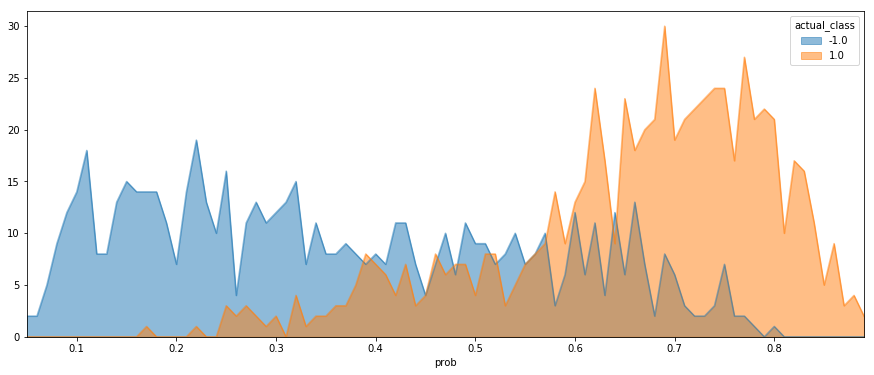

In [545]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_train.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_train).round(2))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

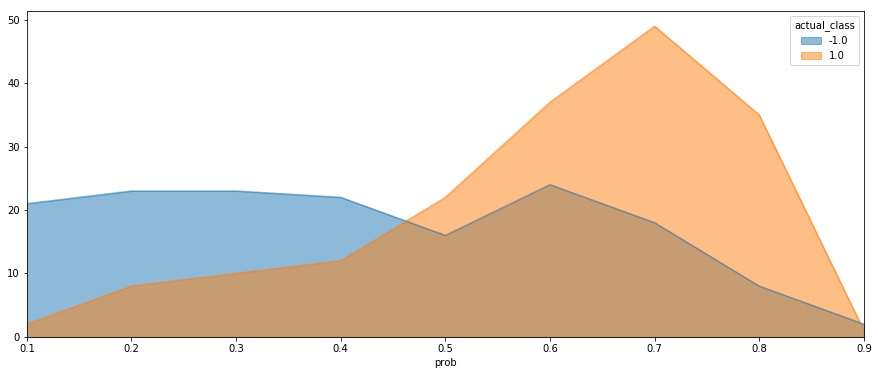

In [546]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_test.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_test).round(1))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

## Feature Selection

In [547]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection(sfs)
sfs = SFS(LogisticRegression(solver='lbfgs'),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'accuracy',
           cv = 5)

sfs.fit(X_train, y_train)
sfs.k_feature_names_

('NSEI_d1',
 'N225_d1',
 'HSI_d1',
 'GDAXI_d1',
 'AXJO_d1',
 'AUD_d1',
 'JPY_d1',
 'IXIC_1_d1',
 'GDAXI_d5',
 'IXIC_1_d5')

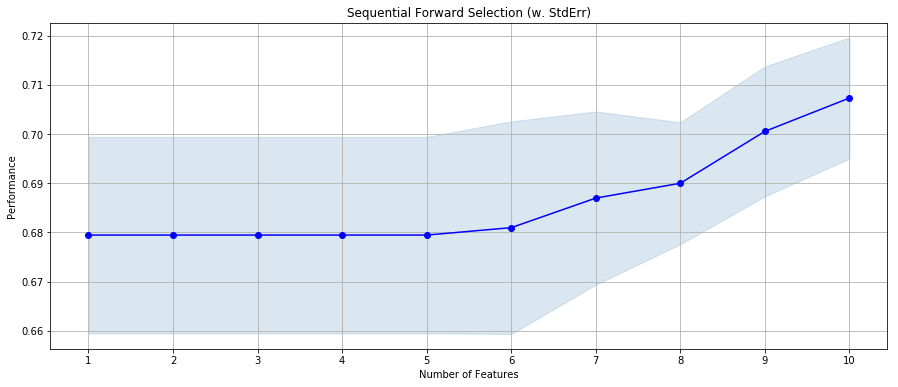

In [548]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [549]:
X_selected_features_train = X_train[list(sfs.k_feature_names_)]
X_selected_features_test = X_test[list(sfs.k_feature_names_)]

### SVM on selected Features

In [550]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_selected_features_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_selected_features_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(accuracy_score(y_train, clf.predict(X_selected_features_train))))

cm_test = confusion_matrix(y_test, clf.predict(X_selected_features_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(accuracy_score(y_test, clf.predict(X_selected_features_test))))

Train Confusion Matrix:
[[428 216]
 [210 475]]
Train Accuracy: 0.6794582392776524

Test Confusion Matrix:
[[110  47]
 [ 54 122]]
Test Accuracy: 0.6966966966966966


### LightGBM on selected Features

In [554]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['lambda'] = 10
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_selected_features_train, label=y_train), 1000)
train_pred = np.where(clf.predict(X_selected_features_train)>=thres, 1, -1)
test_pred = np.where(clf.predict(X_selected_features_test)>=thres, 1, -1)

cm_train = metrics.confusion_matrix(y_train, train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(accuracy_score(y_train, train_pred)))

cm_test = metrics.confusion_matrix(y_test, test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(accuracy_score(y_test, test_pred)))

Train Confusion Matrix:
[[429 215]
 [158 527]]
Train Accuracy: 0.7193378480060195

Test Confusion Matrix:
[[103  54]
 [ 45 131]]
Test Accuracy: 0.7027027027027027


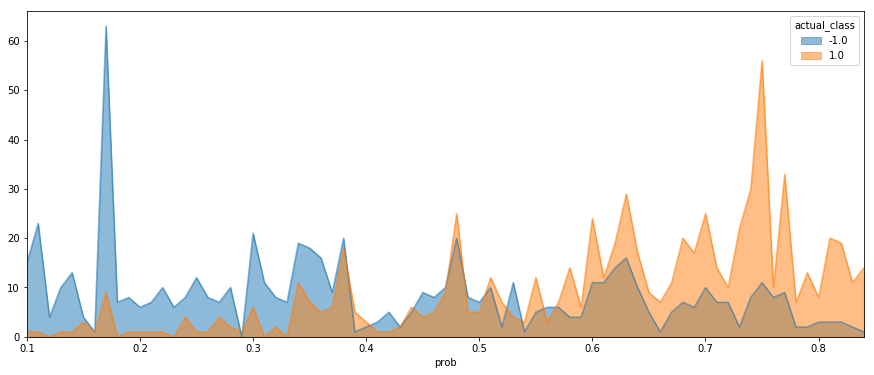

In [555]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_train.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_selected_features_train).round(2))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

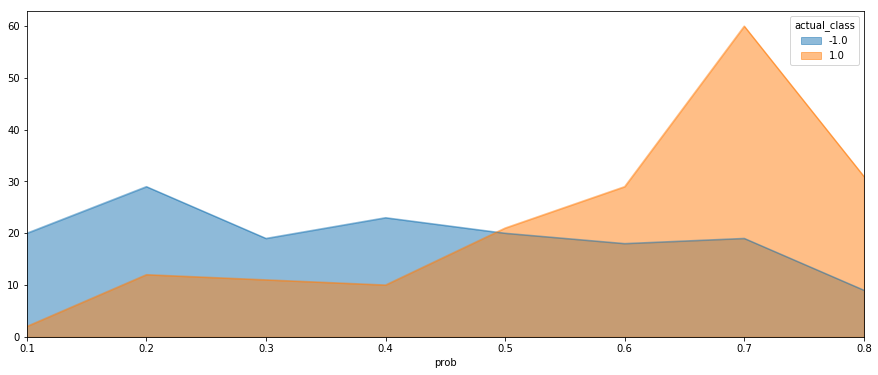

In [556]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_test.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_selected_features_test).round(1))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)